# MSM of the alanine dipeptide

In [12]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import mdtraj as md
from mastermsm.trajectory import traj

First we read the data using the [`MDtraj`](http://mdtraj.org) library.

In [14]:
tr = traj.TimeSeries(top='data/alaTB.gro', traj=['data/protein_only.xtc'])
print tr.mdt

<mdtraj.Trajectory with 10003 frames, 19 atoms, 3 residues, and unitcells>


Then we discretize the data using Ramachandran states. Only alpha and extended configurations are accepted.

In [15]:
tr.discretize(states=['A', 'E'])
tr.find_keys()

Using the discretized data we build the MSM invoking the `SuperMSM` class.

In [16]:
from mastermsm.msm import msm
msm_alaTB = msm.SuperMSM([tr])


 Building MSM from 
[['data/protein_only.xtc']]
     # states: 2


We then calculate the transition matrix for a set of lag times.

In [17]:
for i in [1, 2, 5, 7, 10, 20, 50, 100]:
    msm_alaTB.do_msm(i)
    msm_alaTB.msms[i].do_trans()
    #msm_alaTB.msms[i].boots(plot=False)

Tge rate can be calculated using a simple Taylor expansion. The  method produces acceptable solutions for short lag times although the result rapidly diverges from the transition matrix relaxation time at long lag times. The rate matrix elements have the following values:

In [18]:
msm_alaTB.msms[1].do_rate()
msm_alaTB.msms[1].rate

/Users/ddesancho/anaconda/lib/python2.7/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/Users/ddesancho/anaconda/lib/python2.7/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


array([[-0.01251929,  0.01726619],
       [ 0.01251929, -0.01726619]])

Alternatively, we can use the lifetime based method, where we use branching probabilities and average lifetimes. The rate is almost identical to that from the Taylor expansion.

In [19]:
msm_alaTB.do_lbrate()
print msm_alaTB.lbrate

[[-0.01251929  0.01730769]
 [ 0.01251929 -0.01730769]]


Finally, we use Buchete and Hummer's maximum likelihood propagator-based method, which is also implemented in MasterMSM.

In [20]:
print type(msm_alaTB.lbrate)
msm_alaTB.msms[1].do_rate(method='MLPB', init=msm_alaTB.lbrate)

<type 'numpy.ndarray'>
755.947964992
758.307546644
758.307546644
756.907986727
757.187297742
757.187297742
757.295943102
758.329877483
756.213165276
756.213165276
756.544376007
756.659537723
759.758952793
758.142516853
755.967001136
756.141261669
756.141261669
756.141261669
755.975260474
756.839473512
756.839473512
756.249913717
756.04359617
756.04359617
756.04359617
756.039114287
756.335892368
756.330561717
756.055193091
756.161030845
756.142300788
756.142300788
756.142300788
756.142300788
756.142300788
756.249219295
756.992165215
756.298853977
756.538813821
756.673475352
756.376077904
756.100517582
756.871188732
756.75982925
755.987080745
755.987080745
755.955868255
755.955868255
755.955868255
755.955868255
755.955868255
756.01470823
756.298511978
756.298511978
756.983957291
756.032534105
756.058007621
756.058007621
756.058007621
756.058007621
756.058007621
756.058007621
756.017472986
756.127505675
756.004917027
756.004917027
756.004917027
756.004917027
756.004917027
756.285792761
75

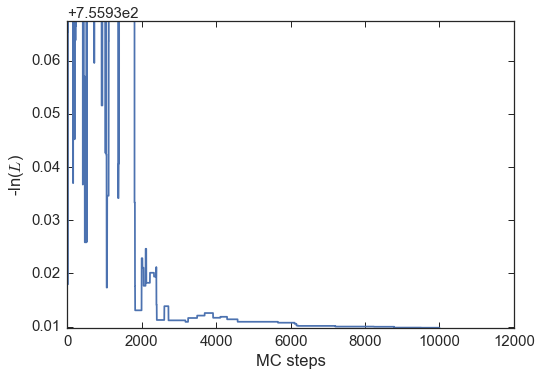

In [21]:
fig,ax = plt.subplots()
ax.plot(msm_alaTB.msms[1].ml)
ax.set_xlabel('MC steps')
ax.set_ylabel('-ln($L$)')
_ = ax.set_ylim(np.min(msm_alaTB.msms[1].ml),np.mean(msm_alaTB.msms[1].ml))